<font size="5">Section 6: Machine Learning</font>

## Housekeeping and Data

In [140]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
from numpy import absolute

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

import eli5

%matplotlib inline

## Lasso Regression (Regularization)

In [67]:
df_store=pd.read_csv('../data/ifood_df.csv')
target = df_store.MntTotal
features = df_store.drop('MntTotal', axis=1)
features.describe()

,Recency,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Single,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntRegularProds,AcceptedCmpOverall
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,...,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.00000
mean,49.009070,51622.094785,0.442177,0.506576,306.164626,26.403175,165.312018,37.756463,27.128345,44.057143,...,0.216327,0.257596,0.034467,0.089796,0.024490,0.504762,0.165079,0.215873,518.707483,0.29932
std,28.932111,20713.063826,0.537132,0.544380,337.493839,39.784484,217.784507,54.824635,41.130468,51.736211,...,0.411833,0.437410,0.182467,0.285954,0.154599,0.500091,0.371336,0.411520,553.847248,0.68044
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-283.000000,0.00000
25%,24.000000,35196.000000,0.000000,0.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.00000
50%,49.000000,51287.000000,0.000000,0.000000,178.000000,8.000000,68.000000,12.000000,8.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,288.000000,0.00000
75%,74.000000,68281.000000,1.000000,1.000000,507.000000,33.000000,232.000000,50.000000,34.000000,56.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,884.000000,0.00000
max,99.000000,113734.000000,2.000000,2.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2458.000000,4.00000


In [68]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [122]:
# Train the Lasso regression model
lasso=Lasso(alpha=0.1, 
            max_iter=10000,
            tol=0.0001)  # You can adjust the alpha value to control the regularization strength
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=0.1, max_iter=10000)

In [118]:
# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.013224224864466587


In [123]:
# define model evaluation method
cv = RepeatedKFold(n_splits=100, n_repeats=3, random_state=1)
# cross validation scores
scores = cross_val_score(lasso, X_train_scaled, y_train, cv=cv, n_jobs=-1, scoring='neg_root_mean_squared_error')
scores=absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: -0.120 (0.021)


<AxesSubplot:xlabel='MntTotal', ylabel='Predicted'>

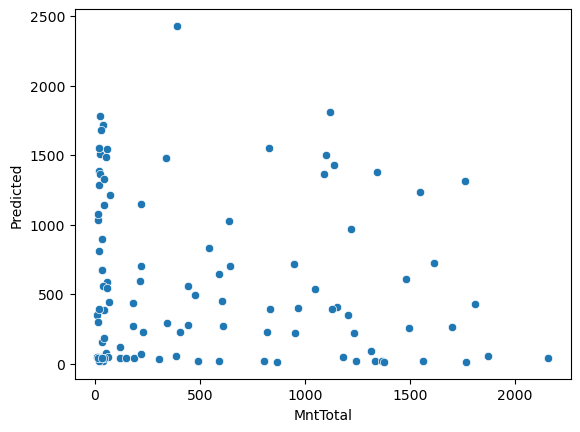

In [124]:
y_pred=pd.DataFrame(y_pred)
y_pred.rename(columns={0 :'Predicted'}, inplace=True )
test = pd.concat([y_test, y_pred], axis=1, join='inner')
sns.scatterplot(data=test, x='MntTotal', y='Predicted')

Feature importance

In [125]:
eli5.show_weights(lasso, top=-1, feature_names = X_train.columns.tolist())

Weight?,Feature
+563.962,<BIAS>
+338.685,MntWines
+216.609,MntMeatProducts
+55.812,MntFishProducts
+41.220,MntSweetProducts
+39.984,MntFruits
+0.418,MntRegularProds
+0.024,NumCatalogPurchases


Tuning alpha

In [128]:
# define model
model = LassoCV(n_alphas=100, cv=cv, n_jobs=-1, max_iter=10000)
# fit model
model.fit(X_train_scaled, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.574118


## Clasification

### Random Forest

In [131]:
target = df_store.Response
features = df_store.drop('Response', axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [138]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training the classifier
rf.fit(X_train, y_train)

# Making predictions on the test set
y_pred = rf.predict(X_test)

# Evaluating the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8820861678004536


Out of the negative response cases (no response) 370 out of 414 are accurately classified, and 19 out of 27 for positive response cases. Total accuracy is 88.2 percent.

In [137]:
confusion_matrix(y_test, y_pred)

array([[370,   8],
       [ 44,  19]], dtype=int64)

Feature importance

<BarContainer object of 38 artists>

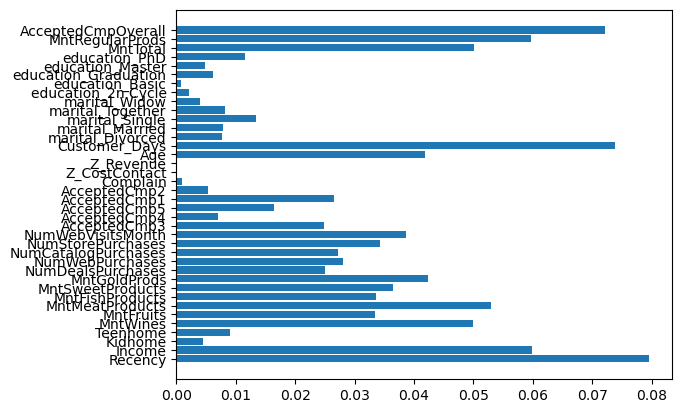

In [144]:
plt.barh(features.columns, rf.feature_importances_)

Now we can turn to tuning the hyperparameters.

In [153]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 8, 16],
    'max_features': [6, 8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

In [154]:
# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)
#grid_search.best_params_
#best_grid = grid_search.best_estimator_

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [4, 8, 16],
                         'max_features': [6, 8], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [155]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
True_16_6_3_8_100,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",1,0.887214,0.014211
True_16_8_3_10_200,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",2,0.886646,0.016836
True_16_8_4_10_200,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",3,0.886646,0.015234
True_16_6_3_8_300,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",4,0.886643,0.015672
True_16_8_3_10_300,"{'bootstrap': True, 'max_depth': 16, 'max_feat...",5,0.886640,0.015492
...,...,...,...,...
True_4_6_4_12_300,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",158,0.866230,0.013298
True_4_6_3_10_300,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",159,0.865672,0.015830
True_4_6_4_8_300,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",160,0.865668,0.015453


### Boosting

### Support Vector Machine

### Stacking

## Clustering

### K-means

### DBSCAN

<font size="3">**Tarea 3**</font>

<u> *Instrucciones* </u>

Los resultados de los ejericicios propuestos se deben entregar como un notebook por correo electronico a *juancaros@udec.cl* el dia 30/6 hasta las 21:00. Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. Utilizar la base de datos segun indicado en las preguntas.

Preguntas:

1. Utilizando ... realice una regresion con regularizacion via Lasso con cross-validation. Muestre que sus resultados son robustos a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

2. Utilizando ... realice una clasificacion de la variable ... usando Random Forest sobre las demas variables del dataset con cross-validation. Muestre que sus resultados son sensibles a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

3. Repita el analisis de la Pregunta 2 usando Stacking, con tres modelos (Random Forest, Gradient Boosting y SVM). Muestre que sus resultados son robustos a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

4. Utilizando ... realice un analisis de cluster usando k-means. Muestre que sus resultados son sensibles a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.

5. Repita el analisis de la Pregunta 4 usando DBSCAN. Muestre que sus resultados son sensibles a la seleccion de hiperparametros y compute una metrica de calidad de ajuste del modelo.